# Deep learning solution to high-dimensional problems
- In this notebook, I applied deep learning techniques to solve a heterogeneous firm model. The techniques were first introduced by Lilia Maliar, Serguei Maliar, and Pablo Winant in their paper "Deep learning for solving dynamic economic models". (DOI: https://doi.org/10.1016/j.jmoneco.2021.07.004)
- Replication codes of Maliar et al. (2021) can be found on Lilia Maliar's personal website: https://lmaliar.ws.gc.cuny.edu/codes/.
- The training of neural networks was implemented within the Tensorflow framework, which no longer supports GPU in Windows system after its 2.10.0 version. Therefore, for those who aim at exploiting GPU in high-performance computing, they might try other frameworks, such as PyTorch.
- The model presented here is a small-scale problem for which the deep learning solution might not be as efficient as conventional approaches.
- However, when handling large-scale problems, such the ones studied in Krusell and Smith (1998) or Khan and Thomas (2013), the deep learning solution outperforms traditional methods.

# Why deep learning?
Most of the dynamic economic models can be written in the following recursive form:
$$
V(s) = \max_{x' \in B(s)} ~F(s,x') + \beta \mathbb{E}[V(s') \vert s]
$$
The solution to this problem is a value function $V(s)$ and a policy function $x'(s)$. In most cases, $V(s)$ and $x'(s)$ do not have analytical forms and cannot be solved using pens and papers. Researchers must rely on numerical methods.

### Discrete state space
One common numerical method is the discrete state space (DSS) approach. To implement DSS, a researcher usually does the following:
  1. Discretize the state space $(s)$, so that the continuous state space and choice sets are replaced by discrete grids. 
  2. Guess a value function $V(s)$ and define it on the grids.
  3. Define the R.H.S. of the Bellman equation on the grids, which serve as the objective for maximization.
  4. Maximize the objective by grid search. Obtain the maximized values and define them as $TV(s)$.
  5. Replace $V(s)$ by $TV(s)$, return to Step 3 and iterate until the distance between $V$ and $TV$ shrinks below a small enought threshold. 
  
The DSS approach is very popular, in the sense that it is simple, intuitive, and has nice convergence properties. However, one problem with the DSS approach is that it is subject to curse of dimensionality: let $m$ be the number of states and $N$ be the number of grid points for each state, then in total the researcher needs to implement maximization on $m^N$ grid points---as the number of states increases linearly, the number of grid points grows exponentially. If there are multiple stochastic shocks in the model, or if the agent has various decision variables, or if the distribution of agents itself becomes a state variable, the DSS approach will be very computationally expensive, or even infeasible. 

### Deep learning
In Maliar et al. (2021), the authors developed a deep learning (DL) approach to overcome the high-dimension challenge:
  1. Choose functions that characterize solutions to the problem (lifetime reward, Euler equation, Bellman equation, etc.). For example, the solution might be characterized by a set of Euler equations:
  $$
  \mathbb{E}_{s} [f_j (s,x',s',x'') ] = 0, \quad i = 1,...,J
  $$
  2. Parameterize the agent's policy functions $x'(s)$ and other key functions using a neural network, denoted by $\varphi(s; \theta)$. $\theta$ are parameters that govern the behavior of the neural network.
  3. Given the chosen function, construct an objective function to be minimized. Suppose the researcher chooses Euler equations to characterize the problem, the corresponding Euler objective function is defined as the expected sum of squared Euler residuals:
  $$
  \Xi(\theta) = \mathbb{E}_{s,s'} [ \xi(s,s';\theta)] = \mathbb{E}_{s} \biggl\{ \sum_{j=1}^J \nu_j \Big(\mathbb{E}_{s'} f_j \Big[ s,\varphi(s;\theta),s',\varphi(s';\theta) \Big] \Big)^2 \biggr\}
  $$ 
  4. Choose a vector of weights $(\nu_1,\dots,\nu_J)$ for the objective function. 
  5. Train the neural network. During training, adjust $\theta$ to minimize NOT the objective function $\Xi(\theta)$, but its empirical estimate $\Xi^n (\theta)$, in which $s$ and $s'$ are sampled from the ergodic set: 
  $$
  \min_{\theta \in \Theta} \Xi^n (\theta) = \min_{\theta \in \Theta} \frac{1}{n} \sum_{i=1}^n \xi(s,s';\theta)
  $$
  6. The idea is to find $\theta^\star$ so that given the parameterized policy function $\varphi(s;\theta^\star)$, the expected sum of squared Euler residuals is approximately zero, indicating that the Euler equations are almost satisfied. 

The DL approach has the following advantages compared to DSS: 
  - Neural networks are extremely powerful at approximating high-dimensional functions with only a few neurons and layers. For example, in Maliar et al. (2021), the authors employed a neural network to approximate the policy functions of a panel of 1,000 agents, which amounts to 2,001 state variables. However, the neural network they adopted has only two hidden layers of $64 \times 64$ neurons.
  - By random sampling and minimizing the empirical estimate $\Xi^n (\theta)$, the authors avoid computing integrals using quadrature points, which are subject to curse of dimensionality. This is crucial when handling models with a lot of stochastic shocks.
  - The DL approach focuses on the ergodic set in which the solution stays, so the researchers don't waste time on computing solutions that are never visited in the equilibrium. 

In the next section I introduce a heterogeneous firm model with multiple stochastic shocks. I then solve it using DL.

# The model
- Consider an economy populated by a continuum of firms, all of which are owned by a representative household. 
- A firm is characterized by four state variables: beginning-of-period capital holding $k$, transitory productivity $\upsilon$, capital quality $\omega$, and persistent productivity $z$. 
- Both $\upsilon$ and $\omega$ are i.i.d. transitory shocks; in particular, $\omega$ satisfies a truncated normal distribution with support $[-4 \sigma_{\omega},0]$. The persistent shock $z$ follows an AR(1) process. 
- Each firm maximizes its own market value by making investment and employment decisions: 
$$
V(k,\upsilon,\omega,z) = \max_{k',n} ~ f(k,n,\upsilon,\omega,z) - wn - [k' - (1 - \delta) \omega k] - AC(k,k') + \mathbb{E}[ m V(k',\upsilon',\omega',z)]
$$
$$
\begin{aligned}
    \text{s.t.} \quad f(k,n,\upsilon,\omega,z) &= e^{z} e^{\upsilon} (e^{\omega} k)^{\alpha} n^{\nu} \\ 
    AC(k,k',\omega) &= \frac{\eta}{2} (k' - \omega k)^2 \\
    z' &= \rho_z z + \epsilon_z^{\prime}, \quad \epsilon_{z} \sim N(0, \sigma_z^2) \\
    \upsilon &\sim N(0, \sigma_{\upsilon}^2) \\ 
    \omega &\sim N(0, \sigma_{\omega}^2), \quad \omega \in [-4 \sigma_{\sigma}, 0] 
\end{aligned}
$$
where $w$ denotes wage, $n$ labor hired, $k'$ next period's capital holding, $AC(k,k',\omega)$ capital adjustment cost, and $m$ the household's stochastic discount factor.  
- The household problem is 
$$
W(\lambda) = \max_{C,N,\lambda'} U(C, 1 - N) + \beta W(\lambda') 
$$
$$
\begin{aligned}
    \text{s.t.} \quad  U(C,1-N) &= \log C - \psi N \\
    C + \int_{S} \rho_1 (k',\upsilon',\omega',z') ~d\lambda' (k',\upsilon',\omega',z') &\leq wN + \int_{S} \rho_0 (k,\upsilon,\omega,z) ~d\lambda(k,\upsilon,\omega,z) 
\end{aligned}
$$
where $\rho_1$ is the price of new shares, $\rho_0$ is the price of old shares, $\lambda$ is the portfolio of firms held by the household with $\lambda'$ chosen for next period, $w$ is the wage. 
- A simpler model was discussed in Simon Mongey's lecture notes (URL: https://www.simonmongey.com/teaching--notes.html). In order to highlight the power of deep learning techniques in dimension reduction, I added the transitory productivity shock and capital quality shock to the model. The idea of capital quality shock comes from Ottonello and Winberry (2020). 
- Mongey further shows that by defining $p = U_1(C,1-N)$, one can rewrite the firm's problem, so that the entire economy is characterized by the following equations:
$$
v(k,\upsilon,\omega,z) = \max_{k'} ~ p [\pi(k,n,\upsilon,\omega,z) - k' + (1 - \delta) \omega k - AC(k,k')] + \beta \mathbb{E}[v(k',\upsilon',\omega',z)]
$$
$$
\begin{aligned}
    \text{s.t.} \quad \pi(k,n,\upsilon,\omega,z) &= f(k,n(k,\upsilon,\omega,z),\upsilon,\omega,z) - w n(k,\upsilon,\omega,z) \\ 
    n(k,\upsilon,\omega,z) &= \Big[\frac{\nu e^{z} e^{\upsilon} (e^{\omega} k)^{\alpha}}{w} \Big]^{\frac{1}{1 - \nu}} \\ 
    p &= \frac{1}{C} \\ 
    w &= \frac{\psi}{p} \\ 
    C &= Y - I - AC = \int_{S} f(k,n,\upsilon,\omega,z) ~d\lambda - \int_S [ k' - (1 - \delta)\omega k] - AC(k,k',\omega)~d\lambda\\ 
\end{aligned}
$$


# Implementation of Maliar et al. (2021)'s deep learning method

## Import relevant libraries
First, type `pip install tensorflow` in Anaconda Prompt to install the Tensorflow libary, which will be used for the training of the neural network. The latest version of Tensorflow might not be compatible with your Jupyter kernel. If that is the case, you need to create a new kernel, and install Tensorflow there. Once the installation is finished, import the libraries below. If library X is missing, you can install it using `pip install X`.

In [1]:
##### Import necessary libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time
from tqdm import tqdm as tqdm       

I then set values for parameters governing the preferences, technology, and stochastic processes. Later I am going to minimize the estimates of an objective function, in which exogenous states and endogenous variables are sampled from the following domain:
- The exogenous states $(\upsilon, \omega, z)$ are sampled from their ergodic distribution. The ergodic distribution of persistent productivity shock $z$ is $N(0, \frac{\sigma_z^2}{1 - \rho_z^2})$. 
- The endogeneous control variable $k$ is sampled from a fix interval $[k_{min}, k_{max}]$ with uniform probability.

In [2]:
# Parameters governing preferences and technology
bbeta=0.99          # Discount factor    
ppsi = 2.4          # Disutility of labor
aalpha = 0.256      # Capital share in production function
nnu = 0.64          # Labor share in production function
ddelta = 0.069      # Capital depreciation rate
eeta = 0.5          # Capital adjustment cost

rrho_z = 0.95       # Autocorrelation of persistent productivity shock
ssigma_z = 0.05     # Standard deviation of persistent productivity shock
ssigma_ups = 0.03   # Standard deviation of transitory productivity shock 
ssigma_omega = 0.04 # Standard deviation of capital quality shock
omega_max = 0       # Upper bound of capital quality shock
omega_min = -4 * ssigma_omega  # Lower bound of capital quality shock

# Parameters governing the ergodic distribution of shocks
ssigma_e_z = ssigma_z / math.sqrt(1.0 - rrho_z**2) # Standard deviation of ergodic productivity distribution
k_min = 0           # Minimum value of capital 
k_max = 20.0        # Maximum value of capital

## Parameterize policy function using neural networks
The firm's investment decision is characterized by a policy function $k'(k,\upsilon,\omega,z)$, which has four inputs and one output. 

Traditionally, economists might approximate continuous functions using projection methods. For example, a researcher might approximate a continuous policy function $f$ with a family of basis functions $P_n(x)$: 
$$
\hat{f}(x;c) = \sum_{j=1}^n c_j p_j(x)
$$
whose basis coefficients $c_1$, $c_2$, $\dots$, $c_n$ are determined by minimizing the "distance" between $f(x)$ and $\hat{f}(x;c)$. 

When applying Maliar et al. (2021)'s approach, I am also approximating the firm's policy function, but using neural networks as "basis functions":
$$
\hat{k'}(s) = \varphi(s;\theta)
$$
where $s = (k, \upsilon, \omega, z)$ and $\theta$ denotes the weights and biases of the neural network. A neural network can be regarded as a function, whose behavior is governed by the weights and biases of each of its neuron (node). The more layers and neurons a neural network has, the more powerful it becomes in capturing nonlinear behaviors. For my problem, I used a neural network with 3 hidden layers and 128 neurons in each layer. 

In [3]:
# Construction of neural network
layers = [
    tf.keras.layers.Dense(128, activation='relu', input_dim=4, bias_initializer='he_uniform'), # Four inputs: k, z, ups, omega
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear) # One output
]
policy_net = tf.keras.Sequential(layers)

# helper to re‐initialize all Dense layers’ kernels & biases
def reinitialize_model():
    he = tf.keras.initializers.HeUniform()
    for layer in policy_net.layers:
        # only reinit Dense layers that actually have kernel & bias
        if hasattr(layer, 'kernel') and hasattr(layer, 'bias'):
            # sample new weights with He‐uniform
            new_kernel = he(shape=layer.kernel.shape)
            # sample new biases with whatever initializer you originally set
            new_bias   = layer.bias_initializer(shape=layer.bias.shape, dtype=layer.bias.dtype)
            layer.set_weights([new_kernel, new_bias])


d:\Anaconda\envs\tf_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Note that:
- On the one hand, $k'(s)$ must take non-negative values, as it is not profitable for a firm to have negative capital holdings. 
- On the other hand, $k'(s)$ must not take arbitrarily large values, otherwise the neural network might converge to explosive solutions during training. 
- In addition, firms with capital state close to $k_{\max}$ might choose $k'(s) > k_{\max}$. 

Given the above concerns, I restrict the output of capital policy function to lie within the interval $[k_{\min}, 1.3 k_{\max}]$. This is done by applying the sigmoid transformation: 
$$
\varphi(s;\theta) = k_{\min} + (1.3 k_{max} - k_{min}) \frac{1}{1 + e^{-\mathcal{N}(s;\theta)}}
$$
where $\mathcal{N}(s;\theta)$ denotes the output of the neural network. 

In [4]:
# Define firm policy function k'(k,z,ups,omega) using the neural network
def k_policy(k,z,ups,omega):

    # Normalize the states
    norm_k = (k - k_min) / (k_max - k_min) * 2.0 - 1.0 # Normalize k so it lies within [-1,1]
    norm_z = z / ssigma_e_z / 3.0     # Normalize z so they are typically between -1 and 1
    norm_ups = ups / ssigma_ups / 3.0   # Normalize ups so they are typically between -1 and 1
    norm_omega = (omega - omega_min) / (omega_max - omega_min) * 2.0 - 1.0    # Normalize omega

    # Stack into [n by 4] matrix
    s = tf.stack([norm_k, norm_z, norm_ups, norm_omega], axis=1)
    x = policy_net(s)

    # Capital policy is nested within [k_min, k_max]
    kp = k_min + (1.3 * k_max - k_min) * tf.sigmoid(x[:, 0])

    return kp


## Optimality conditions as residuals
The firm's optimality condition is characterized by the following Euler equation: 
$$
1 + \eta (k - \omega k') = \beta \mathbb{E}_{\upsilon', \omega', z'} \Big[ \alpha e^{\omega'} e^{\upsilon'} e^{z'} (e^{\omega'} k')^{\alpha - 1} {n'}^{\nu} + (1 - \delta) \omega' + \eta \omega' (k'' - \omega' k') \omega' \Big\vert z \Big]
$$
$$
\begin{aligned}
    \text{s.t.} \quad n'(k',\upsilon',\omega',z') &= \Big[\frac{\nu e^{z'} e^{\upsilon'} (e^{\omega'} k')^{\alpha}}{w'} \Big]^{\frac{1}{1 - \nu}} \\ 
    k' &= \varphi(s;\theta) \\ 
    k'' &= \varphi(s';\theta)
\end{aligned}
$$
Then, the Euler residual is defined as
$$
R(s,s') = 1 + \eta (k - \omega k') - \beta \mathbb{E}_{\upsilon', \omega', z'} \Big[ \alpha e^{\omega'} e^{\upsilon'} e^{z'} (e^{\omega'} k')^{\alpha - 1} {n'}^{\nu} + (1 - \delta) \omega' + \eta \omega' (k'' - \omega' k') \omega' \Big\vert z \Big]
$$
where $s = (k,\upsilon,\omega,z)$

In [5]:
# Define the optimal labor given states (k,z) and wage rate w
def optimal_labor(k,z,ups,omega,w):

    # Compute the optimal labor choice
    n = (nnu * tf.exp(z) * tf.exp(ups) * (tf.exp(omega) * k)**aalpha / w)**(1.0 / (1.0 - nnu))

    return n


# Define the FOC residual
def residuals(e_z, ups_next, omega_next, k, z, ups, omega, w):
    
    # Current period's labor and investment decisions
    kp = k_policy(k,z,ups,omega)          # Optimal investment k'(k,z)

    # Tomorrow's states and optimal decisions
    z_next = z * rrho_z + e_z   # Tomorrow's persistent productivity
    np_next = optimal_labor(kp,z_next,ups_next,omega_next,w) # Tomorrow's optimal labor n'
    kp_next = k_policy(kp,z_next,ups_next,omega_next) # Tomorrow's investment decision k''

    # Intertemporal Euler residual
    R = (1.0 + eeta * (kp - tf.exp(omega) * k)) - bbeta*(tf.exp(omega_next) * tf.exp(z_next) * tf.exp(ups_next) * aalpha * 
        ((tf.exp(omega_next) * kp_next)**(aalpha-1.0)) * (np_next**(nnu)) + (1.0 - ddelta) * tf.exp(omega_next) 
        + eeta * tf.exp(omega_next) * (kp_next - tf.exp(omega_next) * kp))

    return R

## Expected sum of Euler residuals
The expected sum of Euler residuals is defined as: 
$$
\Xi(\theta) = \mathbb{E}_{s} \biggl[\Big( \mathbb{E}_{s'} R(s,s') \Big)^2  \biggr]
$$
It is difficult to compute the above term directly, as it involves computing a squared expectation. More specifically, squared expectation does not equal expectation of square:
$$
\mathbb{E}_s \Big[ (\mathbb{E}_{s'} R(s,s'))^2 \Big] \neq \mathbb{E}_{s} \mathbb{E}_{s'} \Big[ R(s,s')^2 \Big]
$$

Maliar et al. (2021) came up with a simple but powerful solution to the above problem---All-in-One (AiO) expectation operator. The idea is that, instead of using the same random draw $s'$ for both $\mathbb{E}_{s'} R(s,s')$ in the square, use two independent random draws $(s_1', s_2')$ for computation. Therefore, 
$$
\mathbb{E}_{s} \Big[ \mathbb{E}_{s_1'} R(s,s_1') \cdot \mathbb{E}_{s_2'} R(s,s_2') \Big] = \mathbb{E}_{s,s_1',s_2'} \Big[ R(s,s_1') \cdot R(s,s_2') \Big]
$$
We can take the expectation operator out of the square, and multiply two sampled residuals directly. In this way, we can rewrite the objective expected sum of Euler residuals as
$$
\Xi(\theta) = \mathbb{E}_{s,s_1',s_2'} \Big[ R(s,s_1') R(s,s_2') \Big] = \mathbb{E}_{\zeta} \Big[ \xi(\zeta;\theta) \Big]
$$
where $\zeta = (s,s_1',s_2')$. 

Note that $\Xi(\theta)$ now is an objective function, which has one single expectation operator with respect to a vector of random variables $\zeta$. We can then approximate $\Xi(\theta)$ by Monte-Carlo simulation: 
$$
\Xi^n (\theta) \approx \frac{1}{n} \sum_{i=1}^n \xi(\zeta;\theta)
$$

In [6]:
# Objective function to be minimized
def objective_function(n, w):
    
    # randomly drawing current states
    z = tf.random.normal(shape=(n,), stddev=ssigma_e_z)
    k = tf.random.uniform(shape=(n,), minval=k_min, maxval=k_max)
    ups = tf.random.normal(shape=(n,), stddev=ssigma_ups)
    omega = tf.random.normal(shape=(n,), stddev=ssigma_omega)
    omega = tf.clip_by_value(omega, clip_value_min=omega_min, clip_value_max=omega_max)

    # Randomly draw 1st and 2nd realizations of shocks
    e1_z = tf.random.normal(shape=(n,), stddev=ssigma_z)
    e2_z = tf.random.normal(shape=(n,), stddev=ssigma_z)
    ups_1 = tf.random.normal(shape=(n,), stddev=ssigma_ups)
    ups_2 = tf.random.normal(shape=(n,), stddev=ssigma_ups)
    omega_1 = tf.random.normal(shape=(n,), stddev=ssigma_omega)
    omega_1 = tf.clip_by_value(omega_1, clip_value_min=omega_min, clip_value_max=omega_max)
    omega_2 = tf.random.normal(shape=(n,), stddev=ssigma_omega)
    omega_2 = tf.clip_by_value(omega_2, clip_value_min=omega_min, clip_value_max=omega_max)

    # Compute the residuals
    R1 = residuals(e1_z, ups_1, omega_1, k, z, ups, omega, w)
    R2 = residuals(e2_z, ups_2, omega_2, k, z, ups, omega, w)

    # All-in-one (AiO) expectation
    R_squared = R1 * R2 

    # Compute the average
    return tf.reduce_mean(R_squared)


## Search for equilibrium price
### Outer loop:
I apply bisection method to solve for the equilibrium price $p$ and equilibrium wage $w$: 
  1. Guess a price $p$, 
  2. Given $p$, compute the implied wage rate $w = \frac{\psi}{p}$, which determines the optimal labor function.
  3. Set up the neural network, the residual function, and the objective function (expected sum of Euler residuals).
  4. Train the neural network to minimize the objective function. 
  5. Once the training completes, we obtain the firm's policy function $k'(s) \approx \varphi(s;\theta^\star)$. 
  6. Given firm's policy function, simulate a panel of 500,000 firms for 200 periods forward. Use the last 100 periods for computing average aggregate consumption $C_{implied}$. 
  7. Compare the guessed aggregate consumption $C_{guess} = \frac{1}{p}$ with $C_{implied}$, and update the guess of $p$ accordingly. Repeat the above process until $\vert C_{guess} - C_{implied} \vert$ falls below the tolerance level.

I set the tolerance level to $1 \times 10^{-2}$ and maximum number of iterations to 12. 

I wrote the code in Python 3.11.11 and trained the neural network using TensorFlow 2.19.0. The code was run on a laptop with 12th Gen Intel(R) Core(TM) i9-12900H (2.50 GHz), RAM 32GB with 14 Cores. The inner loop takes around 4mins, and the outer loop takes around 30+ mins. If you do not want to search for general equilibrium and only want to explore the deep learning method per se, set `maxIter = 1` so that the inner loop runs only once.

### Inner loop: 
This corresponds to Step 4 in the Outer loop. 
- When training the neural network, I use ADAM as the optimizer, with learning rate $1 \times 10^{-3}$. I set the `amsgrad` option to `True` in order to improve the robustness of the result. Readers can also switch to other optimizers such as SGD.
- There are 50,000 training periods, with each training batch containing 512 observations. Larger batch size will reduce the variance of training, but it also make the training more time-consuming.
- I compute the maximum RMSE of the last 1,000 periods for sanity check. If the maximum RMSE is greater than 0.1, the resulting $\theta$ will be rejected, the neural network will be reinitialized and the training will restart with the price unchanged. This is because the Euler equation has multiple solutions, and with very little probability the neural network might give explosive solutions that violate the transversality condition. I do the sanity check in order to rule out the explosive solutions. 
- The neural network has 3 hidden layers and 128 neurons. The number of neurons is large, which is necessary for capturing the nonlinear behavior of capital policy function. Reducing the number of neurons will speed up the code, but it will also make the approximation less accurate. 


In [7]:
print(tf.__version__)

2.19.0


In [8]:
# Parameters governing the training, simulation, and bisection
z_min = -3.0 * ssigma_e_z    # Minimum productivity
z_max = 3.0 * ssigma_e_z     # Maximum productivity
N_sample = 512          # Number of samples in Adam optimizer
N_training = 50000      # Number of training steps
N_errs_check = N_training-1000  # Starting number of error checking (to rule out explosive solutions) 
N_firm = 500000         # Number of firms in the simulation
T_simul = 200           # Simulation period
T_burn = 100            # Period burned
tol_err = 0.1           # Tolerance of Euler error

# Initialization
iter = 0            # Number of iteration
restart = 0         # Number of restart
p_lb = 0.5          # Price lower bound
p_ub = 10.0         # Price upper bound
maxIter = 12        # Maximum number of bisection
maxRestart = 5      # Maximum number of restarting neural network training due to explosive solution
# maxIter = 30      
tol = 1e-2          # Tolerance for consumption market clearing
p_in = np.zeros(maxIter) # Store the price guess (for debugging)
p_out = np.zeros(maxIter) # Store the price implied (for debugging)

# Fix a global seed so everything is reproducible
tf.random.set_seed(1234)
np.random.seed(1234)

# Pre-draw initial cross-section of firm states
k0 = tf.ones(N_firm, dtype=tf.float32) * 0.1
z0 = tf.random.normal(shape=(N_firm,), stddev=ssigma_e_z)

# Pre-draw all shocks for all periods
eps_z = tf.random.normal(shape=(T_simul, N_firm),mean=0.0,stddev=ssigma_z)
eps_ups = tf.random.normal(shape=(T_simul, N_firm),mean=0.0,stddev=ssigma_ups)
eps_omega = tf.random.normal(shape=(T_simul, N_firm),mean=0.0,stddev=ssigma_omega)
eps_omega = tf.clip_by_value(eps_omega, clip_value_min=omega_min, clip_value_max=omega_max)

# Bisection 
t0 = time.time()
while (iter < maxIter) and (restart < maxRestart):

    results = []
    
    # Compute the midpoint price
    p_trial = 0.5 * (p_lb + p_ub)

    # Compute corresponding wage rate
    w_trial = ppsi / p_trial 


    #--------------------------------
    #    Set up ADAM optimizer
    #--------------------------------

    # Reinitialize the neural network weights and biases
    reinitialize_model()
    ttheta = policy_net.trainable_variables
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, amsgrad=True)
    
    @tf.function
    def training_step(m,w):

        with tf.GradientTape() as tape:
            xx = objective_function(m,w)

        grads = tape.gradient(xx, ttheta)
        optimizer.apply_gradients(zip(grads,ttheta))

        return xx

    def train_me(N_training,N_sample,w):
        vals = []
        for k in tqdm(range(N_training)):
            val = training_step(N_sample,w)
            vals.append(val.numpy())

        return vals
    
    # Train the neural network at given price
    results = train_me(N_training, N_sample, w_trial)

    # Check the error
    errs = np.array(results)
    max_rmse = np.sqrt(max(errs[N_errs_check:]))

    if max_rmse <= tol_err: # Update the price only if Euler error is below the threshold

        #--------------------------------
        # Simulate the firm distribution
        #--------------------------------

        # Vectors that store the aggregates
        Y_agg = np.zeros(T_simul)
        z_agg = np.zeros(T_simul)
        K_agg = np.zeros(T_simul)
        I_agg = np.zeros(T_simul)
        AC_agg = np.zeros(T_simul)
        C_agg = np.zeros(T_simul)

        # Impose initial states
        k_simul = k0
        z_simul = z0

        # Simulation
        for tt in range(T_simul):

            # Shocks:
            z_shock = eps_z[tt]
            ups_shock = eps_ups[tt]
            omega_shock = eps_omega[tt]

            # Compute optimal labor choice
            n_simul = optimal_labor(k_simul,z_simul,ups_shock,omega_shock,w_trial)

            # Compute firm's investment decision
            kp_simul = k_policy(k_simul,z_simul,ups_shock,omega_shock)
            kp_simul = tf.clip_by_value(kp_simul, clip_value_min=k_min, clip_value_max=k_max)

            # Compute aggregates
            Y_agg[tt] = float(tf.reduce_mean(tf.exp(z_simul) * tf.exp(ups_shock) * ((tf.exp(omega_shock) * k_simul)**aalpha) * (n_simul**nnu)))
            z_agg[tt] = float(tf.reduce_mean(z_simul))
            K_agg[tt] = float(tf.reduce_mean(tf.exp(omega_shock) * k_simul))
            I_agg[tt] = float(tf.reduce_mean(kp_simul - (1.0 - ddelta) * tf.exp(omega_shock) * k_simul))
            AC_agg[tt] = float(tf.reduce_mean(0.5 * eeta * (kp_simul - tf.exp(omega_shock) * k_simul)**2))
            C_agg[tt] = Y_agg[tt] - I_agg[tt] - AC_agg[tt]

            # Update capital state
            k_simul = kp_simul

            # Update productivity state
            z_simul = tf.clip_by_value(rrho_z*z_simul + z_shock, clip_value_min=z_min, clip_value_max=z_max)

        # Compute the aggregate consumption 
        C_eq = C_agg[T_burn:].mean()

        # Compute the implied equilibrium price
        p_eq = 1.0 / C_eq

        # Store the two prices
        p_in[iter] = p_trial
        p_out[iter] = p_eq

        # Check convergence
        C_trial = 1.0 / p_trial
        if abs(C_trial - C_eq) < tol: 
            break

        # Update bounds
        if p_trial < p_eq:
            # Guess was too low → move lower bound up
            p_lb = p_trial
        else:
            # Guess was too high → move upper bound down 
            p_ub = p_trial

        # Update number of iteration
        iter = iter + 1
    else: 
        restart = restart + 1

100%|██████████| 50000/50000 [03:53<00:00, 214.28it/s]


C:\Users\yijia\AppData\Local\Temp\ipykernel_11304\453171400.py:6: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt(errs), label='training RMSE')


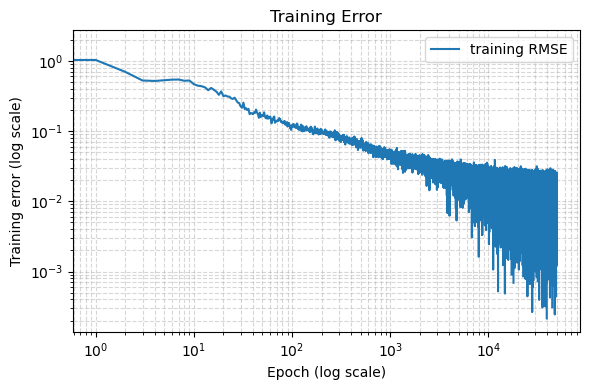

In [9]:
# # 1) Plot training error -----------------------------------------------------
# `results` should be a Python list or 1D array of the objective (R_squared) at each epoch.
errs = np.array(results)
plt.close()
plt.figure(figsize=(6,4))
plt.plot(np.sqrt(errs), label='training RMSE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epoch (log scale)')
plt.ylabel('Training error (log scale)')
plt.title('Training Error')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

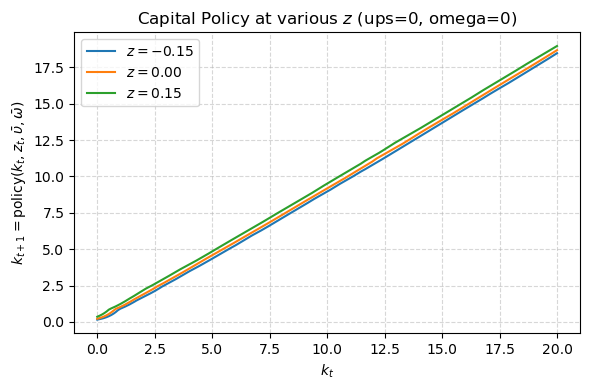

In [10]:
# 2) Plot kp = k_policy(k,z) for various z, holding ups=0, omega=0
plt.close()
k_grid = np.linspace(k_min, k_max, 200, dtype=np.float32)
zbar   = z_agg[T_burn:].mean()
z_vals = [zbar - 3*ssigma_z, zbar, zbar + 3*ssigma_z]

plt.figure(figsize=(6,4))
for z0 in z_vals:
    k_tf     = tf.constant(k_grid)
    z_tf     = tf.constant(np.ones_like(k_grid)*z0, dtype=tf.float32)
    ups_tf   = tf.zeros_like(k_tf)      # hold ups=0
    omega_tf = tf.zeros_like(k_tf)      # hold omega=0

    kp_tf = k_policy(k_tf, z_tf, ups_tf, omega_tf)
    plt.plot(k_grid, kp_tf.numpy(), label=f"$z={z0:.2f}$")

# 45° reference
# plt.plot(k_grid, k_grid, 'k--', label='45°')
plt.xlabel(r"$k_t$")
plt.ylabel(r"$k_{t+1} = \mathrm{policy}(k_t,z_t,\bar\upsilon,\bar\omega)$")
plt.title("Capital Policy at various $z$ (ups=0, omega=0)")
plt.legend(); plt.grid(ls='--', alpha=0.5); plt.tight_layout()
plt.show()

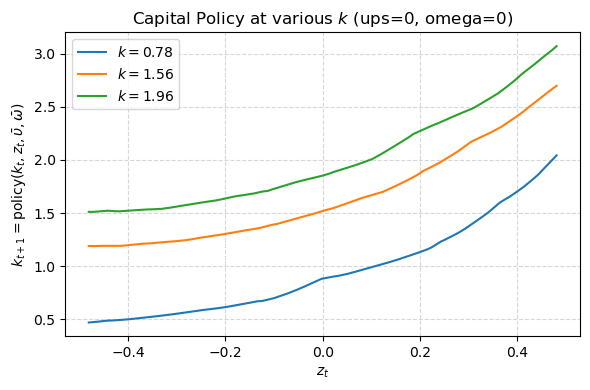

In [11]:
# 3) Plot kp = k_policy(k,z) for various k, holding ups=0, omega=0
plt.close()
z_grid = np.linspace(z_min, z_max, 200, dtype=np.float32)
kbar   = K_agg[T_burn:].mean()
k_levels = [0.5*kbar, kbar, 1.25*kbar]

plt.figure(figsize=(6,4))
for k0 in k_levels:
    k_tf     = tf.constant(np.ones_like(z_grid)*k0, dtype=tf.float32)
    z_tf     = tf.constant(z_grid, dtype=tf.float32)
    ups_tf   = tf.zeros_like(z_tf)      # hold ups=0
    omega_tf = tf.zeros_like(z_tf)      # hold omega=0

    kp_tf = k_policy(k_tf, z_tf, ups_tf, omega_tf)
    plt.plot(z_grid, kp_tf.numpy(), label=f"$k={k0:.2f}$")

# reference: k'=k
# plt.plot(z_grid, z_grid*0 + k_levels[0], 'k--', alpha=0.7, label="45°")
plt.xlabel(r"$z_t$")
plt.ylabel(r"$k_{t+1} = \mathrm{policy}(k_t,z_t,\bar\upsilon,\bar\omega)$")
plt.title("Capital Policy at various $k$ (ups=0, omega=0)")
plt.legend(); plt.grid(ls='--', alpha=0.5); plt.tight_layout()
plt.show()

## Summary 
My own impression of the deep learning method is as follows: 

### Pros
- **Easy to code**: By employing the deep learning technique, a researcher can solve a high-dimensional heterogeneous-agent model in fewer than 300 lines of code. This is almost impossible if the researcher follows a conventional approach.
- **Flexibility**: Neural networks are powerful tools for approximating high-dimensional functions. This makes it an ideal tool for solving high-dimensional problems, i.e. models with multiple shocks, models with a great number of decision variables, or models in which distribution of agents becomes a state variable. 
- **Dimension reduction**: Neural networks can condense a huge number of variables without losing relevant information. If a researcher has multiple functions with the same inputs and outputs, he/she can approximate all of them using one singel neural network. For instance, in Maliar et al. (2021), a neural network with 2 hidden layers and $64 \times 64$ neurons was used to approximate the decision rules of 1,000 agents in a Krusell-Smith model, which has in total 2,001 state variables. 

### Cons
- **No guarantee for convergence**: Unlike conventional VFI, the deep learning method does not guarantee convergence to the "correct" solution. If the researcher didn't restrict the value of input/output of the neural network properly, the neural network might converge to explosive solutions or no solution at all. 
- **Hard to integrate into heterogeneous-agent GE models**: Neural networks are powerful in approximating agent's policy functions, conditional on knowing equilibrium prices. If the researcher does not know the equilibrium price, he/she must re-train the neural network whenever prices are updated. This can be very time-consuming (as can be seen in the above bisection example). A potential solution is to add the market clearing residual into the objective function and treat prices as training variables, so that the neural network can approximate the policy function and solve for equilibrium prices simultaneously. However, this might not work for heterogeneous-agent models: to evaluate the market clearing residual, the researcher must obtain the stationary distribution of agents and compute the aggregate outcomes. But the computation of stationary distribution of agents can be quite expensive. 
- **Accuracy v.s. Time**: There is a trade-off between accuracy of approximation and training time. If the researcher wants to obtain a good approximation of the policy function, he/she must add more neurons and layers to the neural network, but this raises the training time. On the other hand, if the researcher is willing to tolerate a larger approximation error for a shorter running time, he/she might not be able to clear the market when searching for equilibrium prices.

### Application scenarios
- **Preliminary Experiment**: If the researcher comes up with a complicated model and wants to study the properties of policy functions and stationary distribution implied by the model, he/she can code and implement the deep learning method as a preliminary experiment. Once they confirm the validity of their model, they can proceed with approaches that are more accurate, more efficient, but also more difficult to code. 
- **Exogenous-price models**: If prices are fixed in the model, or if the researcher considers a pure optimization problem without any agent interaction, then deep learning can be applied safely for model-solving, as the researcher does not need to retrain the neural network over and over again. 